### Genome-wide perturb-seq

This notebook prepares a dataset from a [paper with giant Perturb-seq experiments](https://www.cell.com/cell/fulltext/S0092-8674(22)00597-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422005979%3Fshowall%3Dtrue) applied to all expressed genes or all essential genes.

Here we tidy the dataset and carry out a simple exploration in scanpy.

We start from a pseudo-bulk version where all cells are added together within each perturbation. 

This study is CRISPRi (knockdown, not knockout).


In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#      visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath =  "../accessory_data/humanTFs.csv"                              # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"

# Replogle2 Specific
dataset_name = "replogle2"
perturbEffectTFOnlyPath = "setup/replogle2TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle2FullTranscriptome.csv"   # a path to store temp file

### Load expression data & set up cell metadata

In [2]:
expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/K562_gwps_raw_bulk_01.h5ad")
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath,
    strip_version=True,
)
expression_quantified

AnnData object with n_obs × n_vars = 11258 × 8248
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

### Fill `perturbation` & `is_control` and find TF's

In [3]:
human_tfs = pd.read_csv(humanTFPath)
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
expression_quantified.obs["gene_symbol"] = [s.split("_")[1] for s in expression_quantified.obs.index]
expression_quantified.obs["is_tf"] = expression_quantified.obs["gene_symbol"].isin(human_tfs["HGNC symbol"])
expression_quantified.obs["ensembl_id"] = [s.split("_")[3] for s in expression_quantified.obs.index]
expression_quantified.obs["is_control"]     = expression_quantified.obs["gene_symbol"].str.contains("non")
expression_quantified.obs["is_control_int"] = expression_quantified.obs["gene_symbol"].str.contains("non").astype("int")
expression_quantified.obs["perturbation"] = expression_quantified.obs["gene_symbol"]
controls = expression_quantified.obs.query("is_control")["perturbation"]
expression_quantified.obs["is_tf"].value_counts()

False    9487
True     1771
Name: is_tf, dtype: int64

### Normalization

In [4]:
pseudobulk = expression_quantified.copy()
pseudobulk.raw = pseudobulk
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

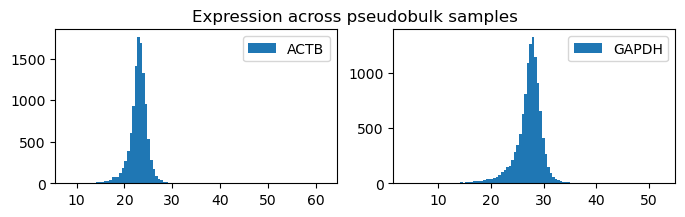

In [5]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'ACTB' ]], bins=100, label="ACTB" )
axes[1].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

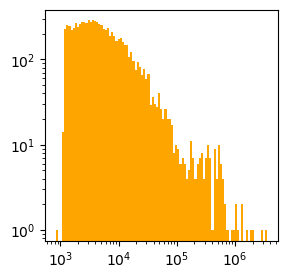

In [6]:
plt.figure(figsize=(3,3))
logbins = np.geomspace(
    pseudobulk.raw.X.sum(axis=0).min(),                    
    pseudobulk.raw.X.sum(axis=0).max(), 
    100)
plt.hist(pseudobulk.raw.X.sum(axis=0), 
         bins=logbins, 
         log=True, 
         color="orange")
plt.xscale('log')
plt.show()

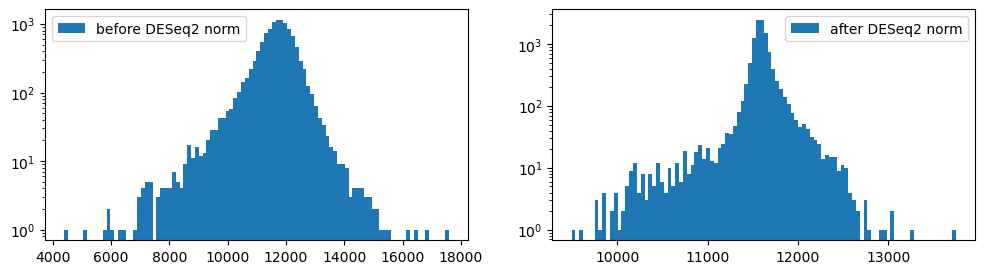

In [7]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(
    pseudobulk.raw.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="before DESeq2 norm")
axes[1].hist(
    pseudobulk.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

UMI_count_unfiltered  num_cells_unfiltered  \
gene_transcript                                                           
33_ABCF1_P1_ENSG00000204574          11995.420898                   202   
34_ABCF1_P2_ENSG00000204574          11671.161133                   304   

                             num_cells_filtered  control_expr  fold_expr  \
gene_transcript                                                            
33_ABCF1_P1_ENSG00000204574               196.0      1.980171   0.308161   
34_ABCF1_P2_ENSG00000204574               294.0      1.980171   0.952016   

                             pct_expr  core_control  mean_leverage_score  \
gene_transcript                                                            
33_ABCF1_P1_ENSG00000204574 -0.691839         False             1.168416   
34_ABCF1_P2_ENSG00000204574 -0.047984         False             0.119521   

                             std_leverage_score  energy_test_p_value  ...  \
gene_transcript                                                       ...   
33_ABCF1_P1_ENSG00000204574            1.291675             0.000100  ...   
34_ABCF1_P2_ENSG00000204574            1.003721             0.188781  ...   

                             z_gemgroup_UMI  mitopercent  TE_ratio  \
gene_transcript                                                      
33_ABCF1_P1_ENSG00000204574         0.21994     0.090143  0.014131   
34_ABCF1_P2_ENSG00000204574         0.03778     0.119711  0.013621   

                             cnv_score_z  gene_symbol  is_tf       ensembl_id  \
gene_transcript                                                                 
33_ABCF1_P1_ENSG00000204574     5.423554        ABCF1  False  ENSG00000204574   
34_ABCF1_P2_ENSG00000204574    -0.587824        ABCF1  False  ENSG00000204574   

                             is_control is_control_int  perturbation  
gene_transcript                                                       
33_ABCF1_P1_ENSG00000204574       False              0         ABCF1  
34_ABCF1_P2_ENSG00000204574       False              0         ABCF1  

[2 rows x 22 columns]

(8248,) (8248,)


SpearmanrResult(correlation=-0.007321268673699879, pvalue=0.5061689710290953)

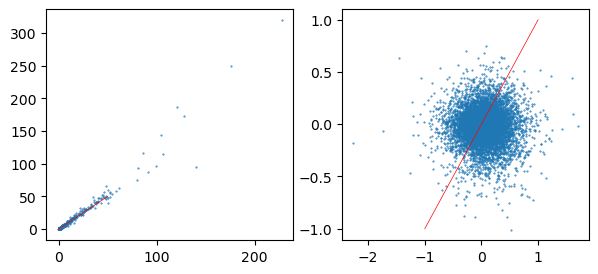

In [8]:
""" Check an exmaple (correlation at expression scale and at logFC scale) """

TFBePerturb = 'ABCF1'
display(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].obs)
expr1 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]
expr2 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]

controlExpr  = pseudobulk[pseudobulk.obs.is_control, :].X
c1 = np.median(controlExpr.copy(), axis=0)

fig, axes = plt.subplots(1,2,figsize=(7,3))
logFC1 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]/c1)
logFC2 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]/c1)
validGeneEntry = np.isfinite(logFC1) & np.isfinite(logFC2)
logFC1 = logFC1[validGeneEntry]
logFC2 = logFC2[validGeneEntry]
print(logFC1.shape, logFC2.shape)
axes[0].scatter(expr1 , expr2 , s=0.2)
axes[0].plot(np.linspace(-1,50,50), np.linspace(-1,50,50), color='red', lw=0.5)
axes[1].scatter(logFC1, logFC2, s=0.2)
axes[1].plot(np.linspace(-1,1,50), np.linspace(-1,1,50), color='red', lw=0.5)
spearmanr(logFC1, logFC2)

### Consistency w/ Perturbation Direction

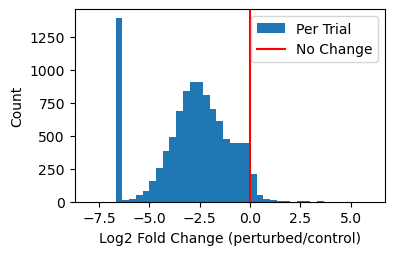

Counter({'Yes': 10118, 'No': 317, 'NA': 823})

In [9]:
# If verbose is set to True, display disconcordant trials and their controls

# Using the fold_expr field it stored in .obs 
# For perturbations where fold_expr = 0, some
# pct_expr = -1, denoting a knockout;
# others are nan, denoting lack of data or control run
fc = pseudobulk.obs.fold_expr.copy()
fc[pseudobulk.obs.pct_expr == -1] = 1e-2  # knockout
logFC = np.log2(fc)
logFC[np.isnan(logFC)] = -999             # control or no data

# Visualize the CRISPRi performance
validLogFC = logFC[logFC != -999]
rangeMin = np.floor(np.min(validLogFC))
rangeMax = np.ceil (np.max(validLogFC))
plt.figure(figsize=(4,2.5))
plt.hist(validLogFC, 
         bins=np.linspace(rangeMin, 
                          rangeMax, 
                          int((rangeMax-rangeMin)*3+1)), 
         label="Per Trial")
plt.axvline(0, 0, 1, color='red', label="No Change")
plt.xlabel("Log2 Fold Change (perturbed/control)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Label knockdown outcome
status = np.full(logFC.shape[0], "NA", dtype=object)
status[(logFC <  0) & (logFC != -999)] = "Yes"
status[(logFC >= 0)] = "No"

pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### Consistency across replications

In [10]:
print(f"Of {pseudobulk.n_obs} observations, {len(set(pseudobulk.obs.perturbation))} unique perturbagen")

Of 11258 observations, 9867 unique perturbagen


[   0 2428] A1BG 1
[1547 1654] AARSD1 2
[2205 2316] ABCA7 3
[2982 3091] ABCB9 4
[3968 4079] ABCF1 5
[5068 5179] ABHD14B 6
[6509 6618] ABL2 7
[6729 6838] ABO 8
[9492 9603] ACIN1 9
[10928 11037] ACP5 10
[1580 1591] ACYP1 11
[1731 1742] ADAR 12
[1776 1787] ADAT3 13
[1952 1963] ADK 14
[2238 2249] AGBL5 15
[2349 2360] AGPAT1 16
[2461 2472] AHCYL1 17
[2515 2526] AHNAK 18
[2859 2870] AKNA 19
[2904 2915] AKR1C2 20
[3504 3515] AMPD2 21
[4376 4387] AP2M1 22
[4593 4602] APC 23
[4781 4792] APOBR 24
[4914 4925] APTX 25
[4947 4958] AQP3 26
[5001 5012] ARAP1 27
[5090 5101] ARF5 28
[5112 5123] ARF6 29
[5387 5398] ARHGAP4 30
[5498 5509] ARHGEF1 31
[5598 5609] ARID1B 32
[5888 5899] ARL6IP1 33
[6131 6142] ARPC2 34
[6153 6164] ARPC3 35
[6175 6187] ARPC4-TTLL3 36
[6209 6220] ARPC5L 37
[6286 6298] ARRDC2 38
[6353 6364] ARVCF 39
[6375 6386] ARX 40
[6982 6993] ATF7IP 41
[7425 7436] ATP5F1A 42
[7844 7855] ATP8B2 43
[8044 8055] ATXN7 44
[8209 8220] B2M 45
[8287 8298] B3GNTL1 46
[8753 8764] BAZ2A 47
[8886 8897] 

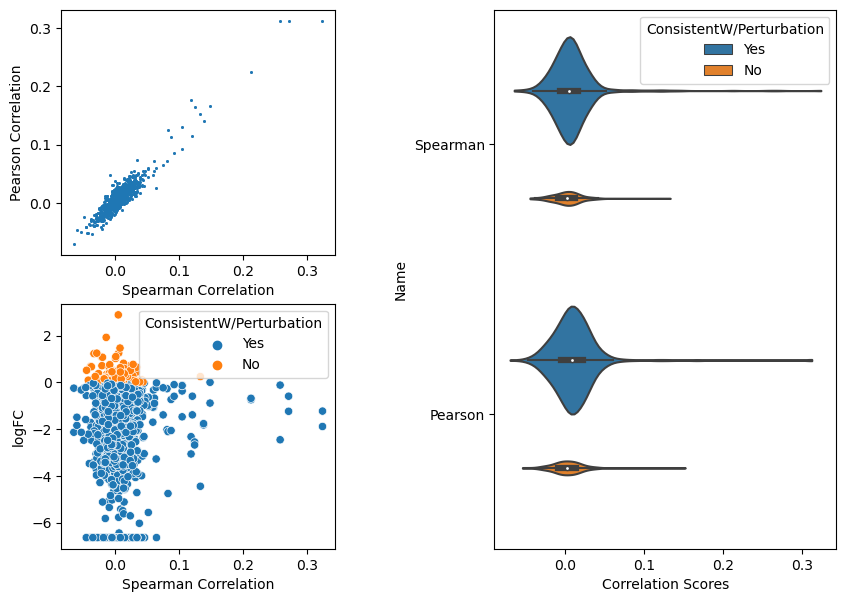

In [11]:
# !! A very small proportion of perturbations have replications
correlations = ingestion.computeCorrelation(pseudobulk, verbose=True)
pseudobulk.obs["spearmanCorr"] = correlations[0]
pseudobulk.obs[ "pearsonCorr"] = correlations[1]

### Perturbation Effect

In [12]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

In [13]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly", 
                         withDEG=False, 
                         withMI=False)

320
0 A1BG -999.0 0.1100516989827156 0.08079102635383606 5.088903427124023 -999.0
1 AAAS -999.0 0.10206253081560135 0.07596708089113235 4.677133560180664 -999.0
2 AACS -999.0 0.1712305247783661 0.12554451823234558 7.845407962799072 -999.0
3 AAGAB -999.0 0.20709215104579926 0.15173792839050293 9.590993881225586 -999.0
4 AAK1 -999.0 0.1336626559495926 0.10039202868938446 6.220520496368408 -999.0
5 AAMDC -999.0 0.1510189026594162 0.11427190899848938 6.771115303039551 -999.0
6 AAMP -999.0 0.18797318637371063 0.14268536865711212 8.665054321289062 -999.0
7 AAR2 -999.0 0.25115686655044556 0.20339849591255188 11.036510467529297 -999.0
8 AARS -999.0 0.51992267370224 0.4188717007637024 23.25381851196289 -999.0
9 AARS2 -999.0 0.12251899391412735 0.09433916211128235 5.5038933753967285 -999.0
10 AARSD1 -999.0 0.11181217432022095 0.08212175965309143 5.075845718383789 -999.0
11 AASDH -999.0 0.2296370416879654 0.16875584423542023 10.70272445678711 -999.0
12 AASDHPPT -999.0 0.15342950820922852 0.112926

In [14]:
ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="",
                         withDEG=False, 
                         withMI=False)

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

2517
0 A1BG -999.0 0.10682235658168793 0.07721994072198868 13.692339897155762 -999.0
1 AAAS -999.0 0.10117771476507187 0.07369158416986465 12.95404052734375 -999.0
2 AACS -999.0 0.16986611485481262 0.12342515587806702 21.505319595336914 -999.0
3 AAGAB -999.0 0.2056857943534851 0.14754700660705566 26.414569854736328 -999.0
4 AAK1 -999.0 0.13107605278491974 0.0935351550579071 16.851646423339844 -999.0
5 AAMDC -999.0 0.14335045218467712 0.10317444801330566 18.804872512817383 -999.0
6 AAMP -999.0 0.1916675567626953 0.14496111869812012 23.588529586791992 -999.0
7 AAR2 -999.0 0.2587047219276428 0.20371630787849426 30.88571548461914 -999.0
8 AARS -999.0 0.5368722677230835 0.4316738545894623 63.85943603515625 -999.0
9 AARS2 -999.0 0.12574005126953125 0.09715740382671356 15.315115928649902 -999.0
10 AARSD1 -999.0 0.10704947263002396 0.07749049365520477 13.484105110168457 -999.0
11 AASDH -999.0 0.2180601954460144 0.1594412922859192 27.63846778869629 -999.0
12 AASDHPPT -999.0 0.15090592205524445 

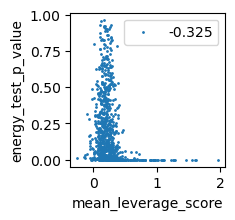

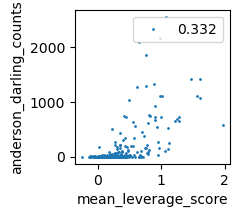

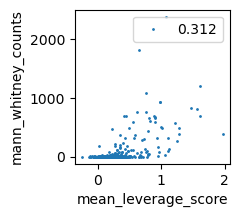

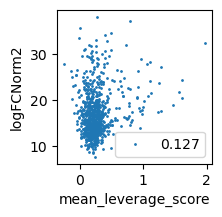

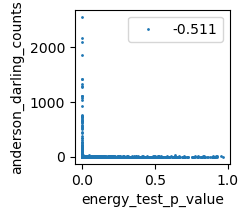

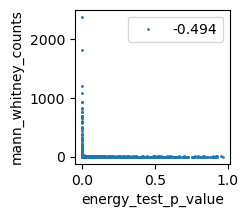

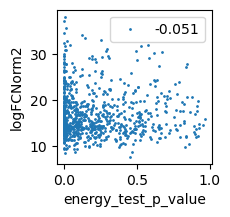

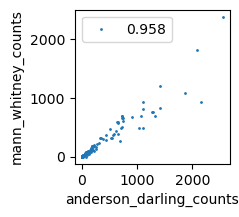

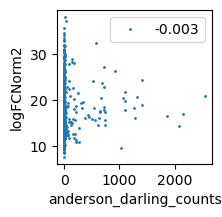

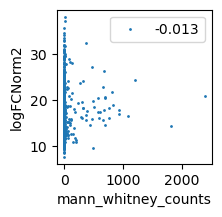

In [15]:
metricOfInterest = ["mean_leverage_score", 'energy_test_p_value', 'anderson_darling_counts', 
                    'mann_whitney_counts', 'logFCNorm2']
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

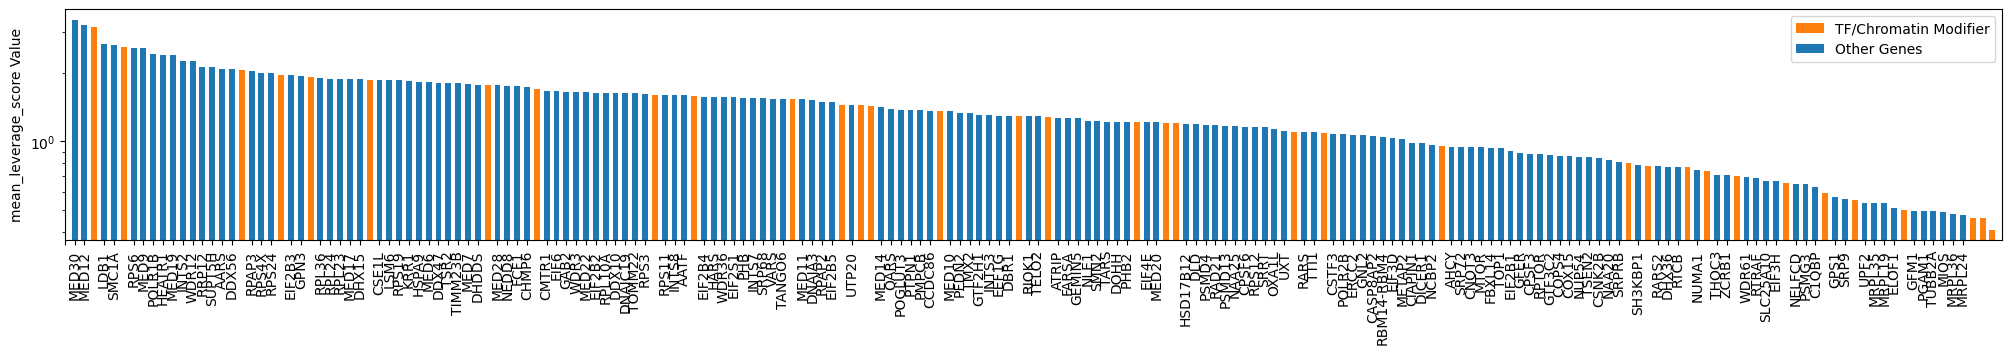

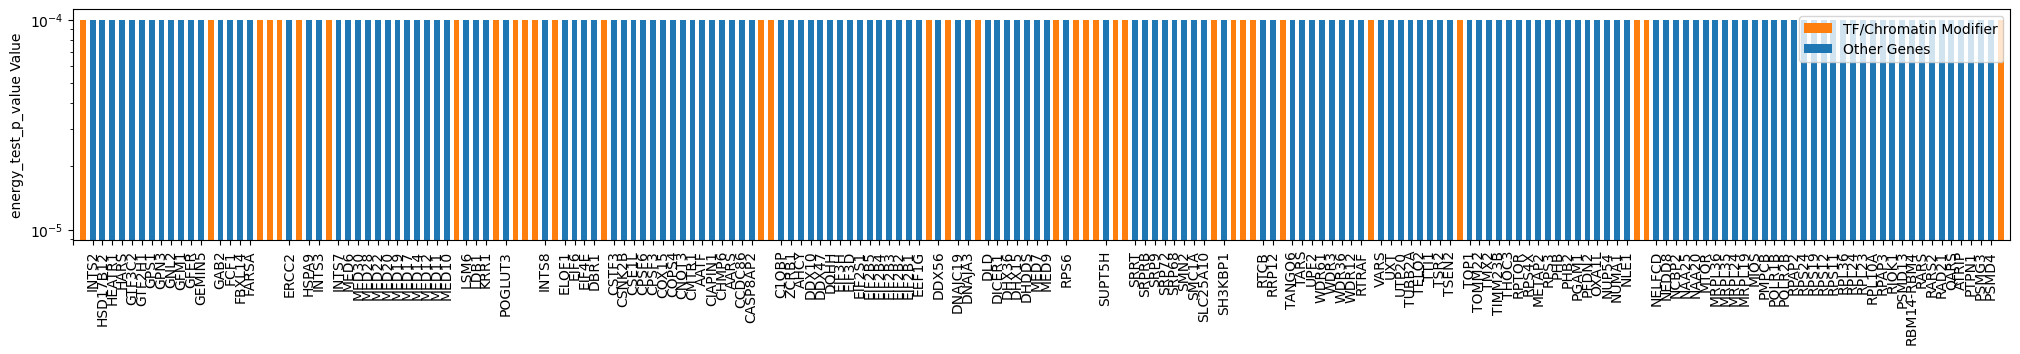

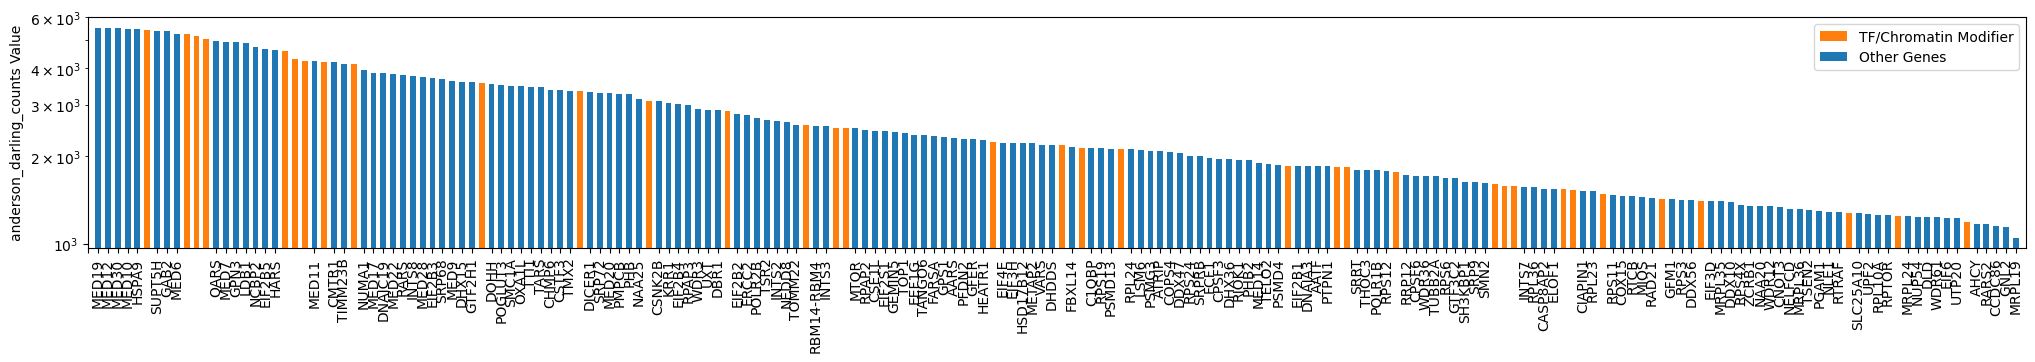

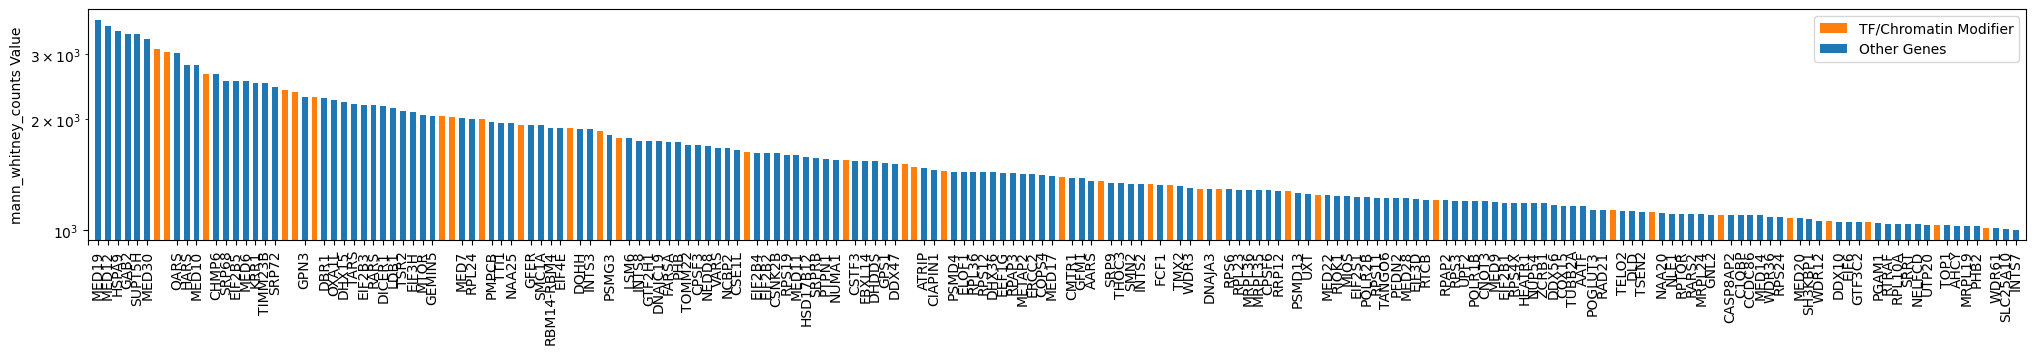

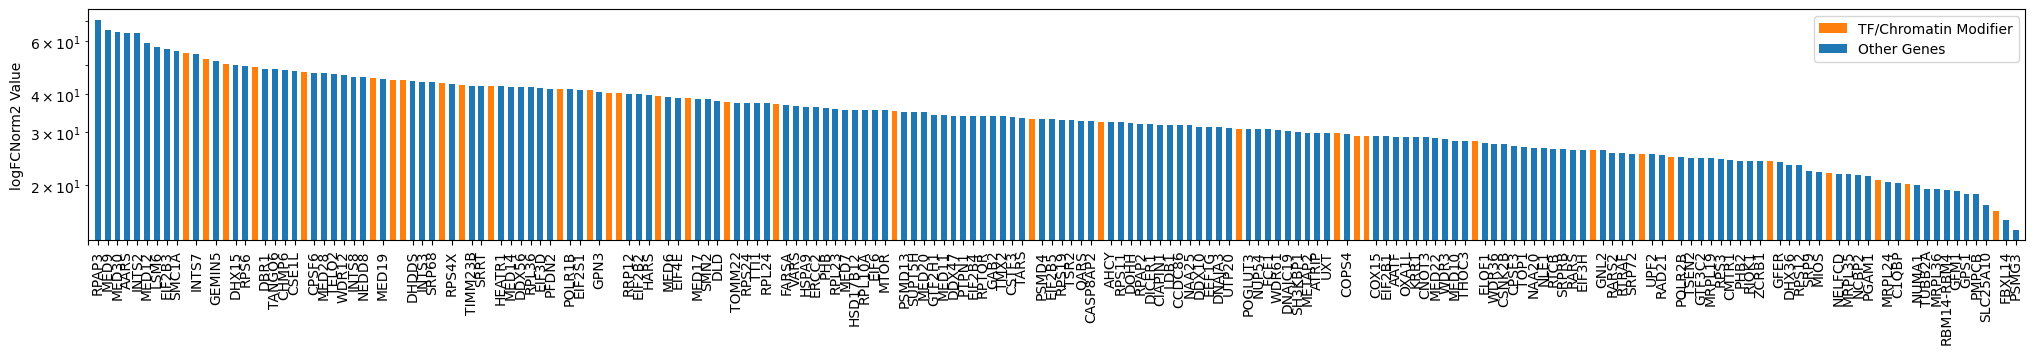

In [16]:
# Unable to look at everything
# Thus, look only at perturbation that results in more than 1000 DEGs
ingestion.visualizePerturbationEffect(
    pseudobulk[pseudobulk.obs.mann_whitney_counts > 1000], 
    metrics=metricOfInterest, 
    TFDict=TFDict, 
    EpiDict=EpiDict
)

In [17]:
for idx, p in enumerate(sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])):
    print(idx, p)

0 ('non-targeting', -999.0)
1 ('PINK1', 6.758049011230469)
2 ('SIMC1', 7.451503753662109)
3 ('HBA2', 7.605693340301514)
4 ('ANAPC15', 7.61685037612915)
5 ('RPL3', 7.792273044586182)
6 ('RHOG', 8.284274101257324)
7 ('STK38L', 8.368706703186035)
8 ('PRODH', 8.473251342773438)
9 ('CADM4', 8.499687194824219)
10 ('ESPN', 8.552245140075684)
11 ('CACNB3', 8.559623718261719)
12 ('CHPF', 8.684288024902344)
13 ('ITPKA', 8.79797649383545)
14 ('NUP205', 8.90650749206543)
15 ('HSPG2', 9.145541191101074)
16 ('KIF11', 9.156436920166016)
17 ('FAM156B', 9.179388999938965)
18 ('TEAD3', 9.265480041503906)
19 ('DDX19B', 9.31807804107666)
20 ('MSN', 9.456561088562012)
21 ('PSTK', 9.4696044921875)
22 ('NSMF', 9.474979400634766)
23 ('DNAJC3', 9.503658294677734)
24 ('PPP2R1A', 9.580072402954102)
25 ('ABHD14B', 9.679656028747559)
26 ('ZNF580', 9.70814037322998)
27 ('RAP1GAP', 9.754786491394043)
28 ('KRT8', 9.84102725982666)
29 ('COQ8A', 9.87196159362793)
30 ('METTL2B', 9.893851280212402)
31 ('AMPD2', 9.9178056

11258 number of points are plotted


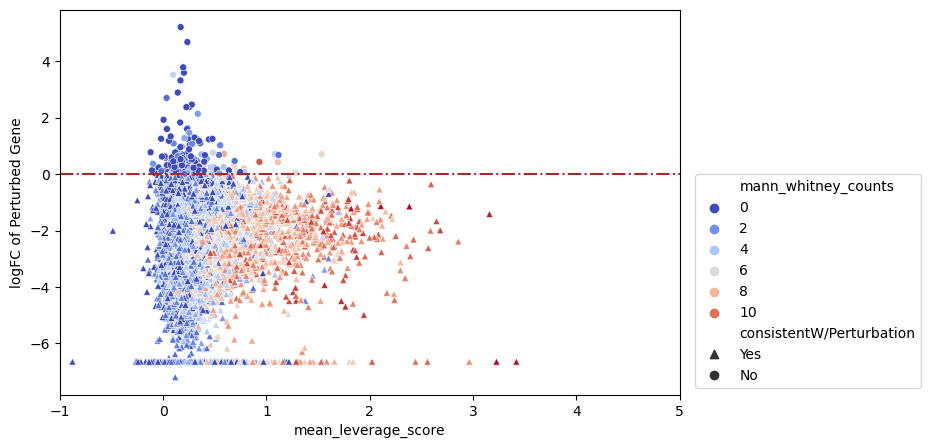

In [18]:
temp = pseudobulk.copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the mann_whitney_counts """
temp.obs['mann_whitney_counts'] = np.log2(temp.obs['mann_whitney_counts']+1)

ingestion.visualizePerturbationMetadata(temp, 
                                        x="mean_leverage_score", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="mann_whitney_counts", 
                                        markers=['^', 'o'],
                                        xlim=[-1, 5], 
                                        s=25)

10435


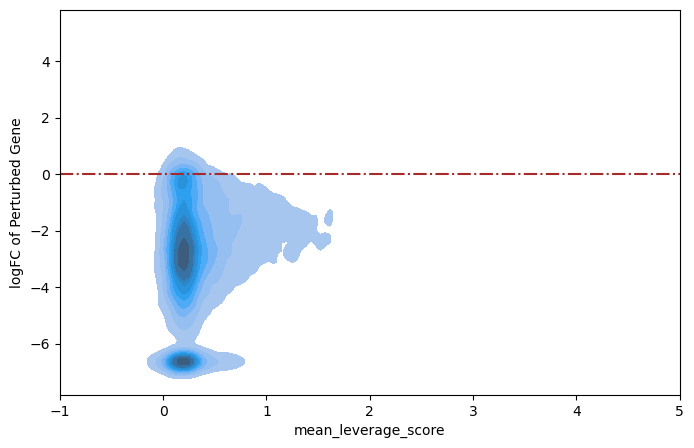

In [19]:
x = "mean_leverage_score"
y = "logFC"
style = "consistentW/Perturbation"
hue = "mann_whitney_counts"
markers = ['^', 'o']
xlim = [-1, 5]
s = 25
adata = pseudobulk

validMat = (adata.obs[x] != -999) & (adata.obs[y] != -999) & (~adata.obs.is_control)
print(sum(validMat))
plt.figure(figsize=(8, 5))


g =sns.kdeplot(data=adata.obs[validMat], 
               x=x,
               y=y,
               palette=sns.color_palette("coolwarm", as_cmap=True), 
               fill=True, 
               gridsize=100, 
               bw_adjust=0.5)
plt.axhline(0, 0, 1, linestyle='-.', color='brown')
plt.ylabel(f"{y} of Perturbed Gene")
plt.xlim(xlim)
plt.show()

### Basic EDA

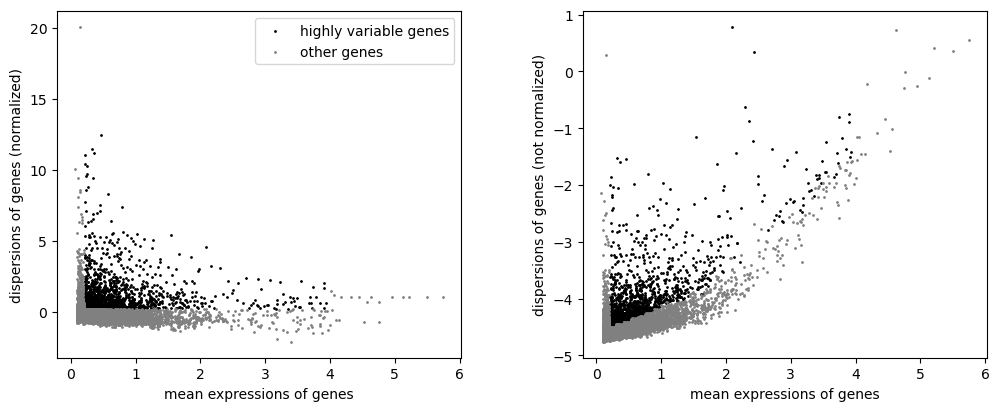

In [20]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)

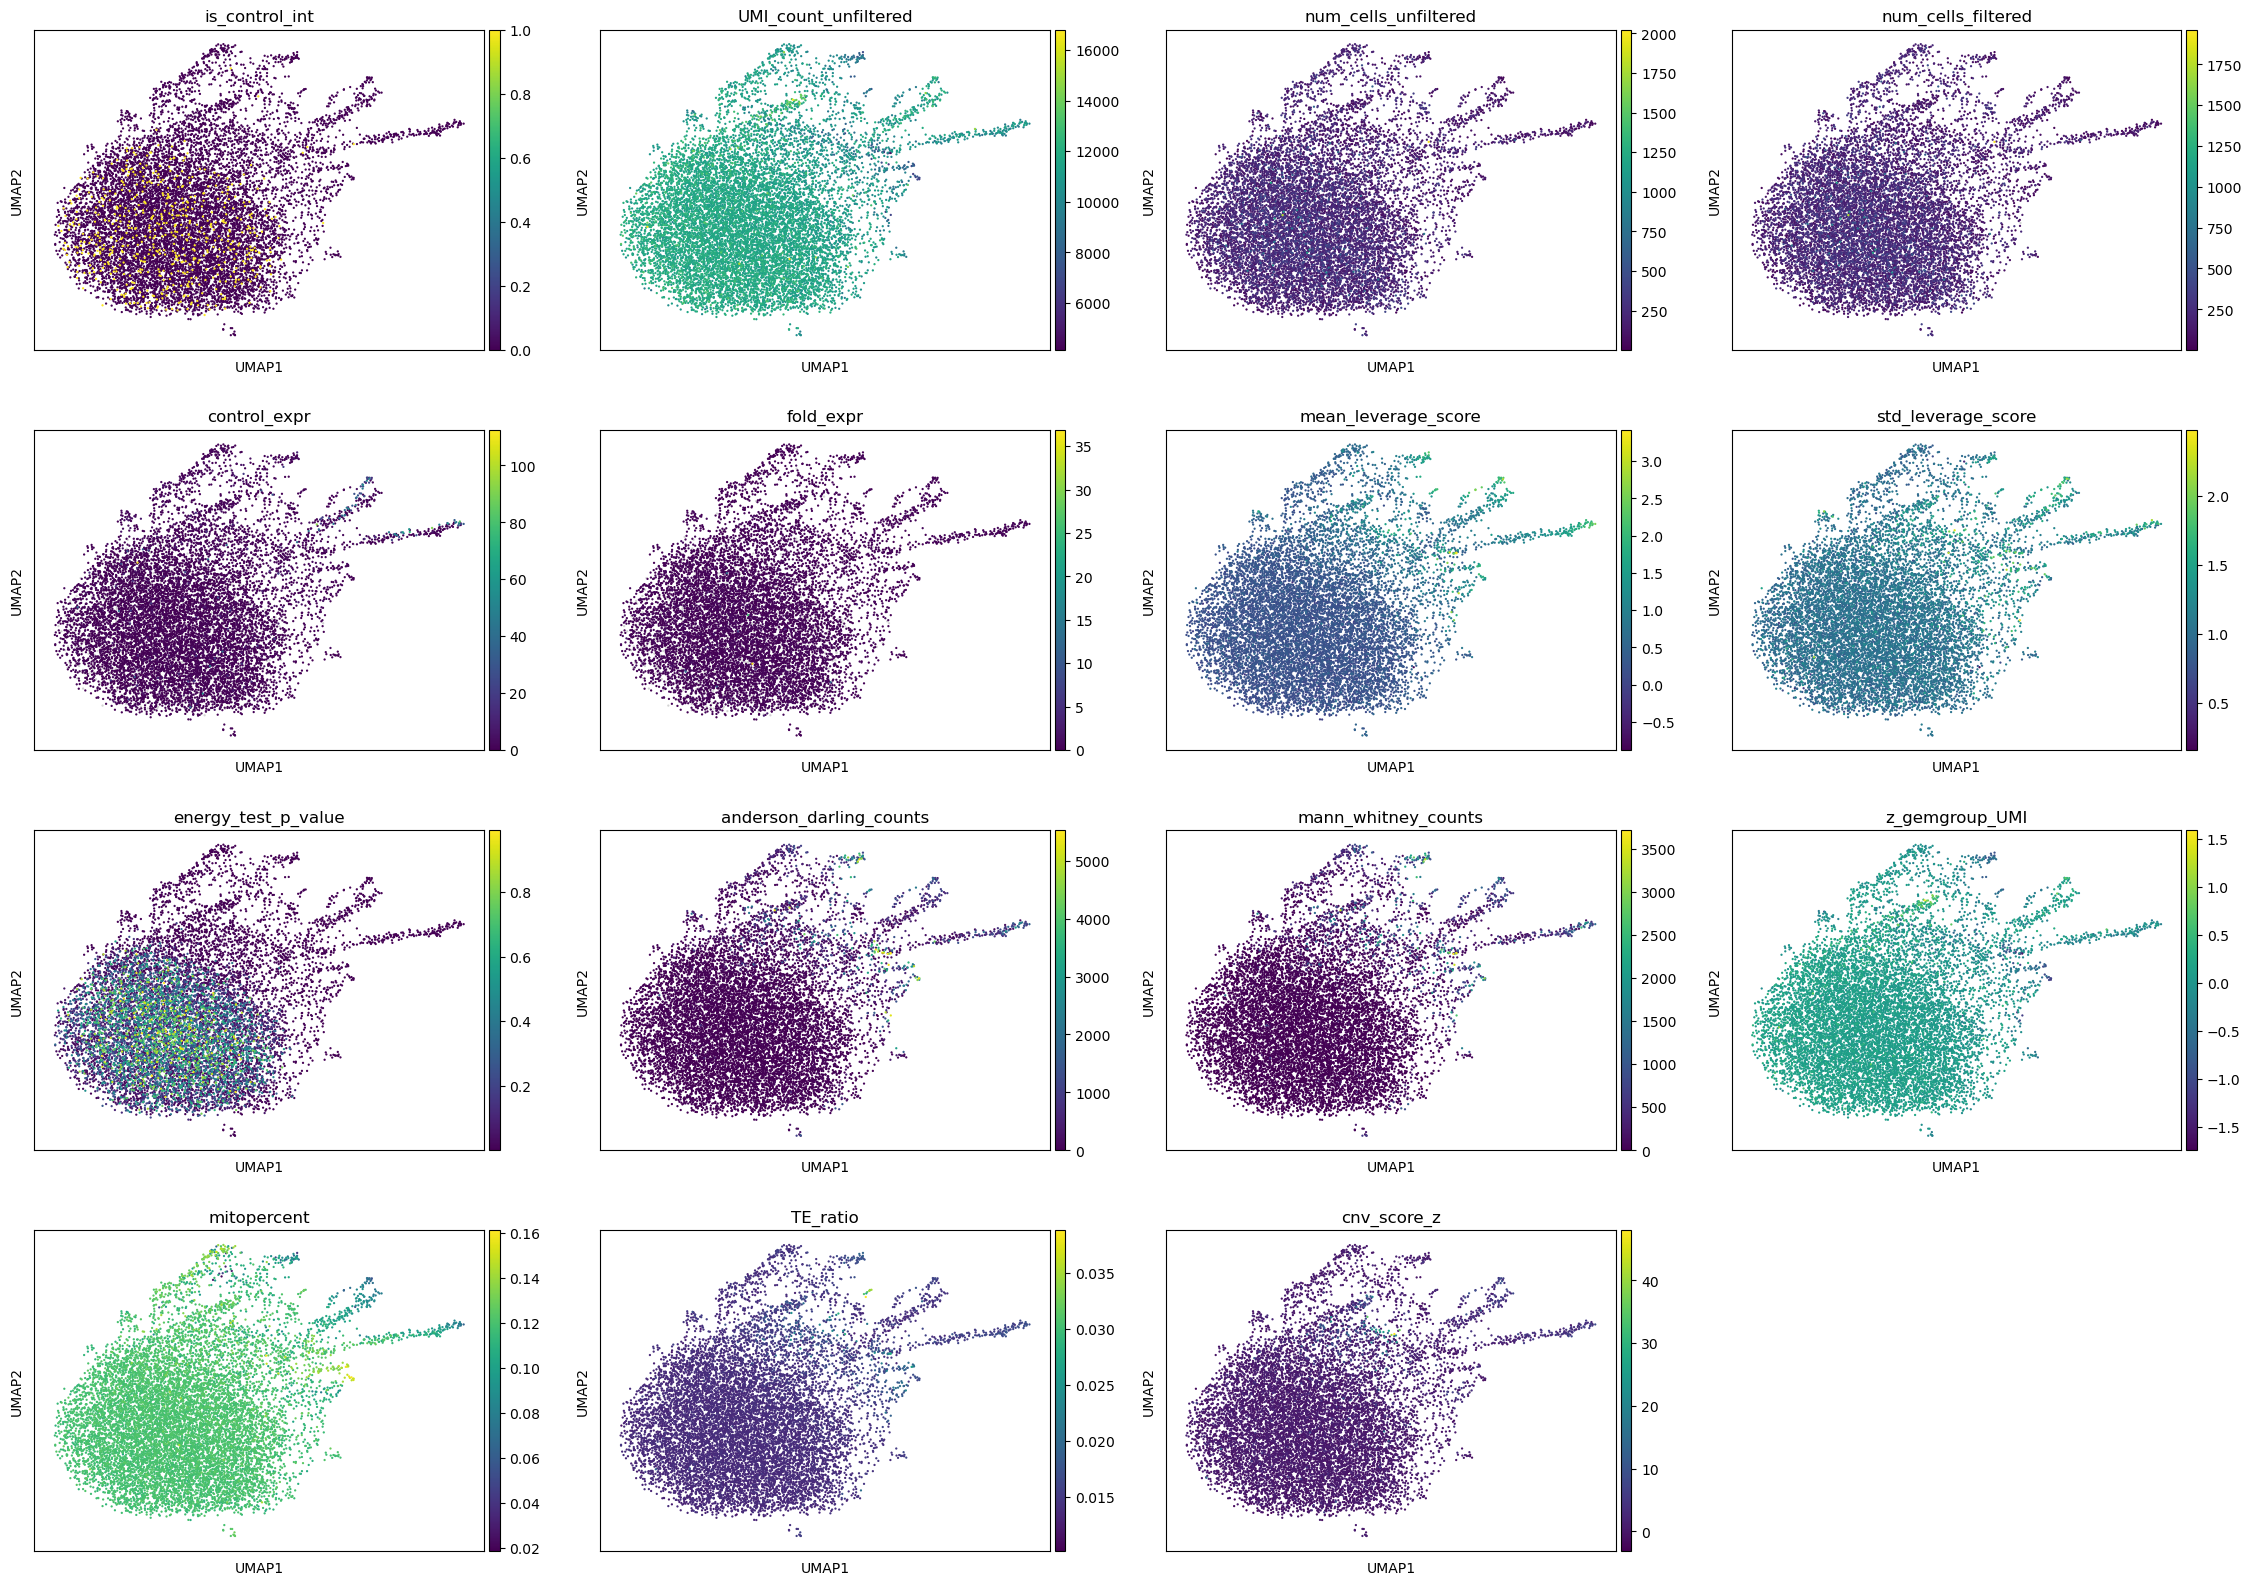

In [21]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    "is_control_int",
    'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered',
       'control_expr', 'fold_expr', 
       'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value',
       'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI',
       'mitopercent', 'TE_ratio', 'cnv_score_z',
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
pseudobulk.obs["fake_cluster"]="all_one_cluster"
pseudobulk.obs.fake_cluster = pseudobulk.obs.fake_cluster.astype("category")
pseudobulk.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction/QC

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [22]:
""" Keep everything that gets correctly knockdown & control & perturbed but not measured """

pseudobulk = pseudobulk[(pseudobulk.obs.logFC < 0) | (pseudobulk.obs.logFC == -999),:].copy()

In [23]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
genes_keep = pseudobulk.var.index[pseudobulk.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
pseudobulk_orig = pseudobulk.copy()
print("This many genes were perturbed:")
print(len(perturbed_genes))
print("These genes were perturbed but not measured:")
print(len(perturbed_but_not_measured_genes))
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

This many genes were perturbed:
9721
These genes were perturbed but not measured:
2181
This many variable genes will be kept and used by CO:
7692


In [24]:
# final form, ready to save
pseudobulk = pseudobulk_orig[:,list(genes_keep)]
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "knockdown")

In [25]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")